In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Traffic Accident Analysis/')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
reports = pd.read_csv('data/monthly_reports.csv', encoding='cp932')

In [ ]:
reports[reports['都道府県コード'] == 30]

,資料区分,都道府県コード,警察署等コード,本票番号,事故内容,死者数,負傷者数,路線コード,地点コード,市区町村コード,...,人身損傷程度（当事者A）,人身損傷程度（当事者B）,地点 緯度（北緯）,地点 経度（東経）,曜日(発生年月日),祝日(発生年月日),認知機能検査経過日数（当事者A）,認知機能検査経過日数（当事者B）,運転練習の方法（当事者A）,運転練習の方法（当事者B）
2010,1,30,69,1,2,0,2,50040,0,102,...,4,2,354115168,1394609243,2,3,9999,9999,9,9
2011,1,30,69,2,2,0,1,50280,0,108,...,2,4,353848129,1394944074,6,3,9999,9999,1,1
2012,1,30,69,3,2,0,1,50150,0,101,...,2,4,354202487,1394504532,5,3,9999,9999,1,1
2013,1,30,69,4,2,0,2,50290,0,122,...,4,2,354503885,1394915620,6,3,9999,9999,1,5
2014,1,30,69,5,2,0,1,50110,0,112,...,4,2,353851691,1394043308,6,3,9999,9999,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283158,1,30,895,209,2,0,1,10500,0,211,...,4,2,354414884,1392756808,7,3,9999,0,5,0
283159,1,30,895,210,2,0,1,10240,0,211,...,4,2,354349816,1393042394,3,3,9999,9999,1,1
283160,1,30,895,211,2,0,1,10250,0,211,...,4,2,354428999,1393003477,5,3,9999,9999,1,9
283161,1,30,896,11,2,0,1,20000,0,361,...,2,0,344702151,1392321913,4,3,9999,0,1,0


In [ ]:
%pip install google-colab-selenium[undetected] --quiet
import google_colab_selenium as gs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 23.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import folium
import io

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
lat_width = 75 / 9000
lon_height = 0.0125

In [ ]:
bottom_lat = 35.7015082
bottom_lon = 139.5221197

In [ ]:
# north, south, east, west = 35.8, 35.6, 139.9, 139.7
north = bottom_lat + lat_width
south = bottom_lat
east = bottom_lon + lon_height
west = bottom_lon

def mean(x, y):
    return (x + y) / 2

map_obj = folium.Map(location=[
    mean(north, south), mean(east, west)], tiles='Cartodb dark_matter no_labels')

square_coordinates = [
    (south, west),
    (north, west),
    (north, east),
    (south, east),
    (south, west)
]

# folium.CircleMarker([south, west], radius=1).add_to(map_obj)
# folium.CircleMarker([north, east], radius=1).add_to(map_obj)
folium.PolyLine(
    locations=square_coordinates,
    weight=7,
).add_to(map_obj)

map_obj.fit_bounds([(south, west), (north, east)])
map_obj

In [ ]:
timeout = 1

img_data = map_obj._to_png(timeout)
img = Image.open(io.BytesIO(img_data))

In [ ]:
img.save('image.png')

In [ ]:
import cv2

image_np = np.array(img)
border_thickness = 8

if image_np.shape[-1] == 4:  # Handle RGBA
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2BGR)
else:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])

mask = cv2.inRange(hsv, lower_blue, upper_blue)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours:
    raise ValueError("No blue box detected in the image.")

largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

x_min = x + border_thickness
y_min = y + border_thickness
x_max = x + w - border_thickness
y_max = y + h - border_thickness

y_min, y_max = min(y_min, y_max), max(y_min, y_max)
x_min, x_max = min(x_min, x_max), max(x_min, x_max)

cropped_np = image_np[y_min:y_max, x_min:x_max]
cv2_image = cv2.cvtColor(cropped_np, cv2.COLOR_BGR2RGB)

cropped_image = Image.fromarray(cv2_image)

In [ ]:
cropped_image.save('image_cropped.png')

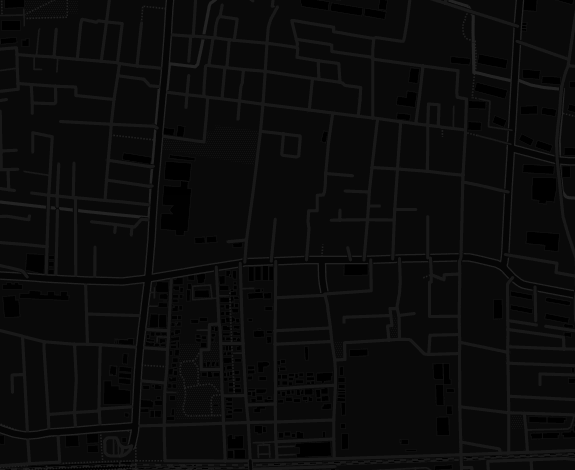

In [ ]:
cv2_imshow(cv2_image)

In [ ]:
def gradient(img):
    kernel = np.ones((5, 5), np.uint8)
    imgf = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    return imgf

def erosion(img):
    kernel = np.ones((3, 3), np.uint8)
    imgf = cv2.erode(img, kernel, iterations=1)
    return imgf

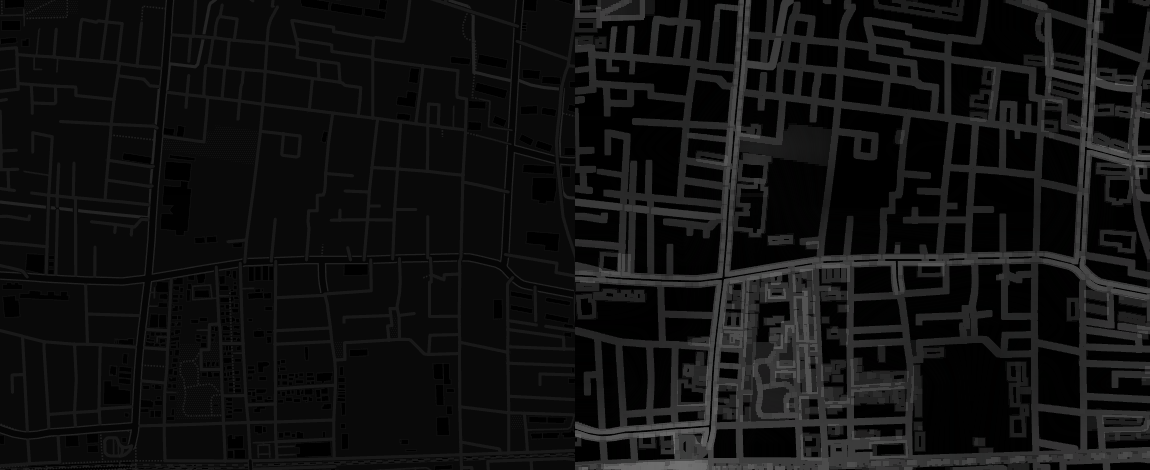

In [ ]:
# cv2_image_copy = cv2.bitwise_not(cv2_image)
cv2_image_copy = cv2_image.copy()
# cv2_image_copy = gradient(cv2_image_copy)
# cv2_image_copy = erosion(cv2_image_copy)

lab = cv2.cvtColor(cv2_image_copy, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8, 8))
cl = clahe.apply(l_channel)

limg = cv2.merge((cl, a, b))

enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
enhanced_img = gradient(enhanced_img)

result = np.hstack((cv2_image, enhanced_img))
cv2_imshow(result)

In [ ]:
edges = cv2.Canny(enhanced_img, 50, 150)
cv2.imwrite("road_outline.png", edges)

True

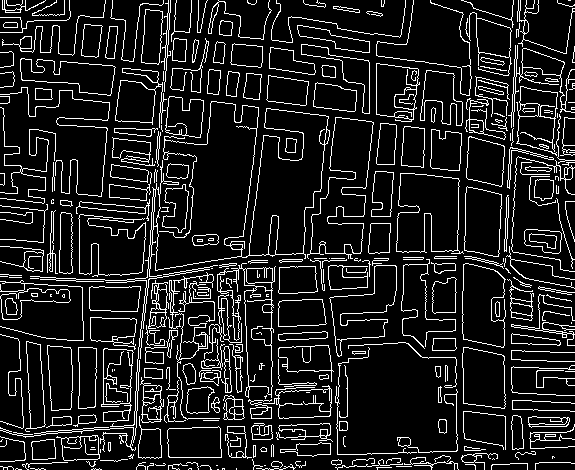

In [ ]:
cv2_imshow(edges)